This notebook describes a workflow for examining a specific source in the GFCat 120-second catalog, following up for more detailed analysis with gPhoton, and then generating images and movies of the target as a quality check. A lot of useful functions are defined along the way. The point of this notebook is not necessarily to recommend this specific workflow (although it is a good one), but provide a framework upon which to hang a lot of useful information and functions about how to work with the GFCat / gPhoton / GALEX data.

This is not intended as complete documentation, however. As a start, also read:
* Morrissey, Patrick, et al. "The calibration and data products of GALEX." The Astrophysical Journal Supplement Series 173.2 (2007): 682.
* Million, Chase, et al. "gPhoton: The GALEX Photon Data Archive." The Astrophysical Journal 833.2 (2016): 292.
* http://www.galex.caltech.edu/researcher/techdocs.html
* Bianchi, Luciana, et al. "New UV-source catalogs, UV spectral database, UV variables and science tools from the GALEX surveys." Astrophysics and space science 363.3 (2018): 56.
* de la Vega, Alexander, and Luciana Bianchi. "Searching for Short-timescale Variability in the Ultraviolet with the GALEX gPhoton Archive. I. Artifacts and Spurious Periodicities." The Astrophysical Journal Supplement Series 238.2 (2018): 25.

#### Setup and housekeeping...

In [1]:
%pylab
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML # requires ffmpeg

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
import sqlalchemy as sql
import pandas as pd
import os

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
import photutils

In [4]:
from gPhoton.MCUtils import angularSeparation, print_inline
from gPhoton.galextools import counts2mag, mag2counts, aper2deg
from gPhoton import PhotonPipe, gAperture
import gfcat_utils as gfu

In [5]:
photdir = '../photom' # Relative path to the local disk location of the photometry data
data_directory='../data' # Relative path to the local disk location that data should be written
band = 'NUV' # NUV has ~10x high countrates than FUV for most types of sources

# Analyze photometry

#### Use GJ65 (aka UV Ceti) as the test source.

In [6]:
skypos = (24.76279, -17.94948) # position of UV Ceti
match_radius = 0.005
eclipse = 13656 # This is one of the UV Ceti eclipses w/ a flare

#### Picking a test visit (e26980).

This visit includes GJ65 (aka UV Ceti) during a time that it flares.

(See _Fleming, S. W., et al. "New Detections Of Time-Resolved GALEX Flares From The GJ 65 System." AAS (2020): 273-10._ w/ paper in review).

In [7]:
photfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv' # This is one of the UV Ceti eclipses
fn = photfile.split('/')[-1]
exptfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv'
phot = pd.read_csv(photfile)
expt = pd.read_csv(exptfile)
total_expt = expt.expt.sum()
print(f'Eclipse {eclipse} summary:')
print(f'   * {round(total_expt)} seconds of exposure')
print(f'   * {len(phot)} unique sources detected')
print(f'   * {len(phot.loc[phot.aperture_sum_mask==0])} unflagged sources')
print(f'\nPhotometry file columns:\n\t{phot.keys()}')
print(f'\nExposure time file columns:\n\t{expt.keys()}')

Eclipse 13656 summary:
   * 1530 seconds of exposure
   * 1652 unique sources detected
   * 1558 unflagged sources

Photometry file columns:
	Index(['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2',
       'npix', 'sky', 'peak', 'flux', 'mag', 'xcenter', 'ycenter',
       'aperture_sum', 'aperture_sum_mask', 'aperture_sum_edge', 'ra', 'dec',
       'aperture_sum_0', 'aperture_sum_1', 'aperture_sum_2', 'aperture_sum_3',
       'aperture_sum_4', 'aperture_sum_5', 'aperture_sum_6', 'aperture_sum_7',
       'aperture_sum_8', 'aperture_sum_9', 'aperture_sum_10',
       'aperture_sum_11', 'aperture_sum_12', 'aperture_sum_13',
       'aperture_sum_14'],
      dtype='object')

Exposure time file columns:
	Index(['expt', 't0', 't1'], dtype='object')


#### The GFCat photometry data are structured as follows:
1. The photometric data are contained in a \*-photom.csv file on a per-eclipse basis.
    * The _id_ column is the source id for this visit / eclipse. The "id" value is unique per visit, but reused across visits, so that "id + eclipse" is unique.
    * The _aperture\_sum_ column is the (interpolated) sum of counts in the photometric aperture on the **full-depth** image.
    * The _aperture\_sum\_\[n\]_ columns are the (interpolated_ sum of counts in the photometric aperture on the **movie** frames.
    * Source detection / measurement was done with DAOphot (via `photutils`). The circular aperture used was equivalent to GALEX "APER6," which is a radius of 12.8". For more accurate absolute photometry, an aperture correction of 0.09 AB Mag is recommended in both bands.
2. The exposure time data are contained in an \*-exptime.csv file on a per-eclipse basis.
    * The row indices of the file corresponded to the suffixes of _aperture\_sum_ in the photometry file.
        * i.e. `expt.iloc[2].expt` (in Pandas syntax) is the effective exposure time for _aperture\_sum\_2_.
    * The _t0_ and _t1_ columns are the bin start and end times in units of "GALEX time" (defined as `UNIX_TIME - 315964800`).
    * The _expt_ column contains the effective exposure time of GALEX within the bin, corrected for "dead time" effects and data dropouts.
    
Keep reading. You don't really need to understand this right now. Several helper functions are defined below in order to sort it all out.

#### Demonstrate that the flagging is meaningful
Eliminating sources with flags set is a very good way to conservatively eliminate false (i.e. non-astrophysical) variables as a first pass. However, false variables may creep through. There may also be flags on perfectly good quality data. The GFCat implements two types of automated artifact flagging: "edge" and "hotspot." The edge flag indicates that a source measurement fell near the edge of the detector, where data quality is known to be significantly degraded by a variety of effects. The hotspot flag indicates that a source measurement overlapped with the mission's hotspot mask at some point. Importantly, GFCat does not _apply_ the hotspot mask, so investigators should independently assess whether a hotspot was active during a specific measurement. One of the best ways to do this is to generate a QA image, a procedure for which is described later in this notebook.

Visit RA range  ==> [24.06, 25.36]
Visit Dec range ==> [-18.57, -17.32]


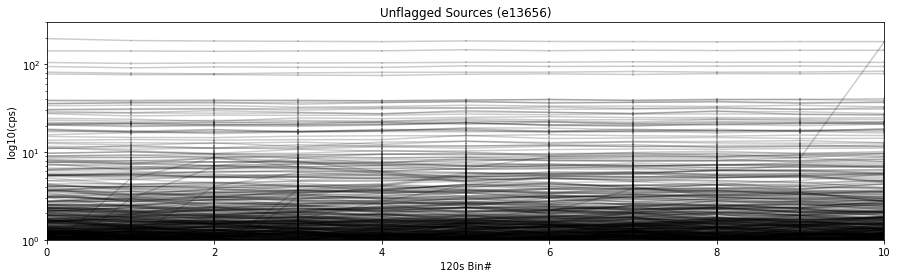

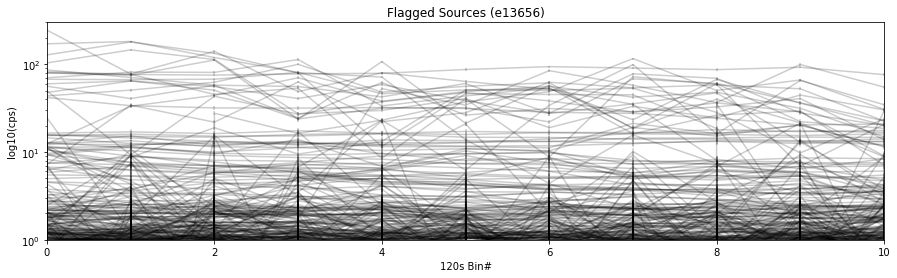

In [8]:
plt.figure(figsize=(15,4))
plt.title(f'Unflagged Sources (e{eclipse})')
for index in phot.index.values:
    if ((phot.loc[index].aperture_sum_mask!=0) |
        (phot.loc[index].aperture_sum_edge!=0)):
        continue
    cnt = phot.loc[index][
            ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
        ].values
    cps = cnt / expt.expt.values.flatten()
    cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
    plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
plt.semilogy()
plt.xlabel('120s Bin#')
plt.ylabel('log10(cps)')
plt.xlim([0,10])
plt.ylim([1,300])

plt.figure(figsize=(15,4))
plt.title(f'Flagged Sources (e{eclipse})')
for index in phot.index.values:
    if not ((phot.loc[index].aperture_sum_mask!=0) |
        (phot.loc[index].aperture_sum_edge!=0)):
        continue
    cnt = phot.loc[index][
            ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
        ].values
    cps = cnt / expt.expt.values.flatten()
    cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
    plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
plt.semilogy()
plt.xlabel('120s Bin#')
plt.ylabel('log10(cps)')
plt.xlim([0,10])
plt.ylim([1,300])

print(f"Visit RA range  ==> [{np.round(phot.ra.min(),2)}, {np.round(phot.ra.max(),2)}]")
print(f"Visit Dec range ==> [{np.round(phot.dec.min(),2)}, {np.round(phot.dec.max(),2)}]")

#### Dump the source positions into an SQLite database.
This provides a ~100000x speed up over using Dask! This might take >30 minutes, but you only ever have to do it once.

In [9]:
def populate_sqlite(regen=False,catdbfile = 'catalog.db',photdir = '../photom'):
    if os.path.exists(catdbfile) and not regen:
        print(f'{catdbfile} already exists.')
        return
    if os.path.exists(catdbfile) and regen:
        os.remove(catdbfile)
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    n_sources = 0
    for i,edir in enumerate(os.listdir(photdir)):
        if 'DS_Store' in edir: # Skip the annoying OSX cruft
            continue
        for csvfile in os.listdir(f'{photdir}/{edir}/'):
            if 'nd-photom' in csvfile:
                photpath = f'{photdir}/{edir}/{csvfile}'
                expt = pd.read_csv(photpath.replace('-photom','-exptime'))
                total_exptime = expt.expt.sum()
                eclipse = int(csvfile.split('-')[0][1:])
                photpath = f'{photdir}/{edir}/{csvfile}'
                phot = pd.read_csv(photpath)
                #print(total_exptime,phot.aperture_sum.values)
                n_sources += len(phot)
                phot['eclipse'] = eclipse
                pos = phot[['eclipse', 'id', 'ra', 'dec', 'xcenter', 'ycenter']]
                pos['exptime'] = total_exptime
                pos['cps'] = np.array(phot.aperture_sum.values)/total_exptime
                pos['cps_err'] = np.sqrt(phot.aperture_sum.values)/total_exptime
                pos['hasmask'] = phot.aperture_sum_mask.values!=0
                pos['hasedge'] = phot.aperture_sum_edge.values!=0
                #pos.to_csv(photpath.replace('-photom','-pos'),index=False)
                pos.to_sql('gfcat', con=engine, if_exists='append' if i!=0 else 'replace')
        if not i%100:
            print_inline(f'Ingesting: {i}')
    # Index on RA, Dec --- this is what we're most interested in searching against
    engine.execute("CREATE INDEX 'ix_gfcat' ON 'gfcat' ('ra', 'dec')")
    engine.dispose()
    print_inline('Source position data dumped to SQLite.\n')
    return

%time populate_sqlite()

catalog.db already exists.
CPU times: user 527 µs, sys: 560 µs, total: 1.09 ms
Wall time: 651 µs


In [10]:
# Test that the database is complete.
def gfcat_count(catdbfile='catalog.db'):
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = engine.execute(f"SELECT COUNT(eclipse) FROM gfcat ").fetchall()
    engine.dispose()
    return out[0][0]

%time assert(gfcat_count()==18340721) # This is how many sources should be in the database

CPU times: user 828 ms, sys: 1.83 s, total: 2.66 s
Wall time: 10.7 s


#### Implement a cone search

In [11]:
def query(query,catdbfile='catalog.db'):
    # This will just run any SQL query that you feed it. The table is named "gfcat"
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = engine.execute(query).fetchall()
    engine.dispose()
    return out

%time brightstars = query(f"SELECT eclipse, id FROM gfcat WHERE hasmask=0 AND hasedge=0 AND cps>622") # 2x the 10% rolloff
print(f'There are {len(brightstars)} very bright stars.\n')

CPU times: user 1.4 s, sys: 272 ms, total: 1.67 s
Wall time: 1.67 s
There are 2795 very bright stars.



In [12]:
def conesearch(skypos,match_radius=0.005,catdbfile='catalog.db'):
    # This runs a box search in SQLite and then refines it into a cone
    out = np.array(query(f"SELECT eclipse, id, ra, dec, xcenter, ycenter FROM gfcat WHERE ra >= {skypos[0]-match_radius} AND ra <={skypos[0]+match_radius} AND dec>= {skypos[1]-match_radius} AND dec<={skypos[1]+match_radius}"))
    dist_ix = np.where(angularSeparation(skypos[0],skypos[1],
                                         out[:,2],out[:,3])<=match_radius)
    return pd.DataFrame({'eclipse':np.array(out[:,0][dist_ix],dtype='int16'),
                         'id':np.array(out[:,1][dist_ix],dtype='int16'),
                         'ra':out[:,2][dist_ix],
                         'dec':out[:,3][dist_ix],
                         'xcenter':out[:,4][dist_ix],
                         'ycenter':out[:,5][dist_ix]})

%time uvceti = conesearch((24.76279, -17.94948)) # Faster because it's searching the indexed columns
print(f'There are {len(uvceti)} UV Ceti observations.')

CPU times: user 4.17 ms, sys: 2.11 ms, total: 6.28 ms
Wall time: 5.38 ms
There are 9 UV Ceti observations.


#### Define functions to get and plot lightcurves given a source position

In [13]:
def get_lightcurves(skypos,match_radius=0.005,debug=False,catdbfile='catalog.db'):
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = np.array(engine.execute(f"SELECT eclipse, id, ra, dec FROM gfcat WHERE ra >= {skypos[0]-match_radius} AND ra <={skypos[0]+match_radius} AND dec>= {skypos[1]-match_radius} AND dec<={skypos[1]+match_radius}").fetchall())
    engine.dispose()
    pos = pd.DataFrame({'eclipse':out[:,0],'id':out[:,1],
                        'ra':out[:,2],'dec':out[:,3]})
    pos['dist'] = angularSeparation(skypos[0],skypos[1],pos.ra.values,pos.dec.values)
    if debug:
        plt.figure(figsize=(5,5))
        plt.title(f'{len(pos)} sources found')
        plt.plot(pos.ra,pos.dec,'k.',alpha=0.7)
        plt.plot(skypos[0],skypos[1],'rx')
        plt.xlim([skypos[0]-max(pos.dist.values)*1.1,skypos[0]+max(pos.dist.values)*1.1])
        plt.ylim([skypos[1]-max(pos.dist.values)*1.1,skypos[1]+max(pos.dist.values)*1.1])
        plt.xticks([])
        plt.yticks([])
    data = {}
    total_expt = 0
    for j in np.arange(len(pos)):
        eclipse = int(pos.iloc[j].eclipse)
        photfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv'
        exptfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv'
        phot = pd.read_csv(photfile)
        expt = pd.read_csv(exptfile)
        total_expt += expt.expt.sum()
        cnt = phot.iloc[j][
                ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
            ].values
        cps = cnt / expt.expt.values.flatten()
        cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
        if debug:
            plt.figure(figsize=(15,3))
            plt.title(f'{j} : e{eclipse} : {int(pos.iloc[j].id)} : {pos.iloc[j].dist}')
            plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
            plt.ylabel('cps')
            plt.xticks([])
        data[j] = {'eclipse':eclipse,
                   'id':pos.iloc[j].id,
                   't0':expt.t0.min(),
                   't1':expt.t1.max(),
                   'photfile':photfile, # filepath
                   'exptfile':exptfile, # filepath
                   'photdata':phot.loc[phot.id==pos.iloc[j].id], # only photometry for source of interest
                   'exptdata':expt,
                   'counts':cnt,
                   'cps':cps,
                   'cps_err':cps_err}
    print(f'Returning {int(total_expt)} seconds of exposure.')
    return data

%time data = get_lightcurves((24.76279, -17.94948))
print(f'\nEach visit has an index (n={len(data.keys())}):\n{data.keys()}')
print(f'\nVisit #0 keys:\n{data[0].keys()}')
print(f'\teclipse: e{(eclipse:=data[0]["eclipse"])}')
print(f'\tsource#: {(sid:=int(data[0]["id"]))}')
print(f'\nPhotometry columns:\n{data[0]["photdata"].keys()}')
print(f'\nWe need the pixel coordinates for later: ({(x:=int(data[0]["photdata"].xcenter))}, {(y:=int(data[0]["photdata"].ycenter))})')
print(f'\nWe also need the time range for later: [{(t0:=data[0]["t0"])}, {(t1:=data[0]["t1"])}]')

# WARNING: Photutils indexes starting at 1 whereas numpy and Pandas starts indexing
#   at zero. The "id" column is defined by the photutils output. So do not try to
#   index with "id" using Pandas `iloc` because it will be wrong by one.

Returning 13520 seconds of exposure.
CPU times: user 117 ms, sys: 12.1 ms, total: 129 ms
Wall time: 137 ms

Each visit has an index (n=9):
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

Visit #0 keys:
dict_keys(['eclipse', 'id', 't0', 't1', 'photfile', 'exptfile', 'photdata', 'exptdata', 'counts', 'cps', 'cps_err'])
	eclipse: e13656
	source#: 804

Photometry columns:
Index(['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2',
       'npix', 'sky', 'peak', 'flux', 'mag', 'xcenter', 'ycenter',
       'aperture_sum', 'aperture_sum_mask', 'aperture_sum_edge', 'ra', 'dec',
       'aperture_sum_0', 'aperture_sum_1', 'aperture_sum_2', 'aperture_sum_3',
       'aperture_sum_4', 'aperture_sum_5', 'aperture_sum_6', 'aperture_sum_7',
       'aperture_sum_8', 'aperture_sum_9', 'aperture_sum_10',
       'aperture_sum_11', 'aperture_sum_12', 'aperture_sum_13',
       'aperture_sum_14'],
      dtype='object')

We need the pixel coordinates for later: (1475, 1647)

We also need the time r

#### Define functions to return photometry data given an eclipse / source id

CPU times: user 18.5 ms, sys: 2.21 ms, total: 20.7 ms
Wall time: 19.3 ms


([], [])

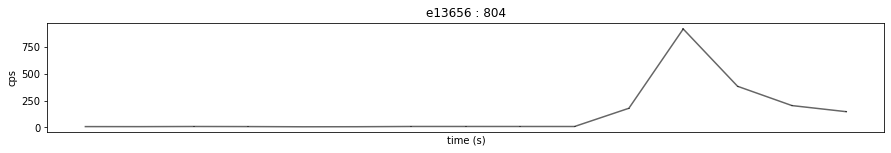

In [14]:
def get_lightcurve(eclipse,sid,photdir = '../photom'):
    # given an eclipse and source id, return the lightcurve data
    phot = pd.read_csv(f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv')
    expt = pd.read_csv(f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv')
    total_expt = expt.expt.sum()
    cnt = np.array([phot.loc[phot.id==sid][f"aperture_sum_{i}"].values[0] for i in np.arange(len(expt))])
    exptimes = expt.expt.values,
    cps = cnt / exptimes
    cps_err = np.sqrt(cnt) / exptimes
    return pd.DataFrame({'t0':expt.t0,'t1':expt.t1,
                         'expt':exptimes[0],'counts':cnt,
                         'cps':(cnt / exptimes[0]),
                         'cps_err':(np.sqrt(cnt) / exptimes[0])})

%time lc120 = get_lightcurve(eclipse,sid,photdir=photdir)
plt.figure(figsize=(15,2))
plt.title(f'e{eclipse} : {sid}')
plt.errorbar(np.array(lc120['t0'])-min(lc120['t0']),lc120['cps'],yerr=lc120['cps_err']*3,fmt='k-',alpha=0.6)
plt.xlabel('time (s)')
plt.ylabel('cps')
plt.xticks([])

# Note: There are error bars on this. They are just smaller than the pixels in this view.

#### Generate gPhoton lightcurves of the target

This will query a database of calibrated photon events at [MAST / STScI](https://archive.stsci.edu/prepds/gphoton/) to generate a higher resolution light curve (w/ 10s bins).

The runtime bottleneck is HTTPS response, and it could take >30 minutes.

In [15]:
stepsz=10 # seconds of lightcurve resolution
gaperfile = '{d}/e{e}/e{e}-{b}d-{s}s.csv'.format(
        d=data_directory, e=eclipse, b='n' if band=='NUV' else 'f', s="{:03d}".format(stepsz)) # output filename
if not os.path.exists(gaperfile):
    # This can take a many minutes to run. The bottleneck is networking overhead.
    lc010 = gAperture(band,skypos,aper2deg(6),trange=[t0,t1],stepsz=stepsz,verbose=2,csvfile=gaperfile)
else:
    lc010 = pd.read_csv(gaperfile)
    print(f'{gaperfile} exists.')

../data/e13656/e13656-nd-010s.csv exists.


Text(0, 0.5, '')

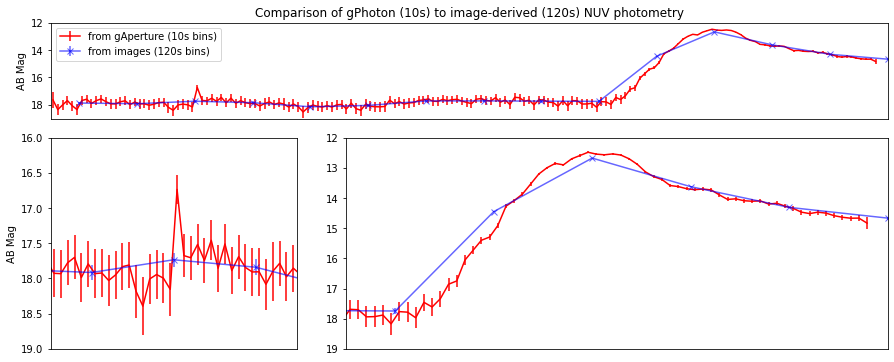

In [16]:
def plot_lc(ax):
    ax.errorbar(lc010['t0']+5,counts2mag(lc010['cps'],'NUV'), # This function converts GALEX countrate to AB Mag
             yerr=counts2mag(lc010['cps'],'NUV')-counts2mag(lc010['cps']+lc010['cps_err']*3,'NUV'),
# The errors in AB Mag (i.e. log-space) are actually asymmetric. This is a linear approximation valid near zero.
             fmt='r-',label='from gAperture (10s bins)')
    ax.errorbar(np.array(lc120['t0'])+60, # offset the timestamp to the bin center
             counts2mag(lc120['cps'],'NUV'),
             yerr=counts2mag(lc120['cps'],'NUV')-counts2mag(lc120['cps']+lc120['cps_err']*3,'NUV'),
             fmt='bx-',alpha=0.6,label='from images (120s bins)')
    #ax.set_xlabel('time (s)')
    ax.set_ylabel('AB Mag')
    ax.set_xlim([lc010['t0'].min(),lc120['t1'].max()-60])
    ax.set_xticks([])

plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
plot_lc(ax1)
ax1.set_ylim([19,12])
ax1.set_title('Comparison of gPhoton (10s) to image-derived (120s) NUV photometry')
ax1.legend()

# Small flare
ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=1,rowspan=2)
plot_lc(ax2)
ax2.set_xlim([lc120['t0'][1],lc120['t1'][3]])
ax2.set_ylim([19,16])

# Big flare
ax3 = plt.subplot2grid((3, 3), (1, 1), colspan=2, rowspan=2)
plot_lc(ax3)
ax3.set_xlim([lc120['t0'][9],lc120['t1'].max()-60])
ax3.set_ylim([19,12])
ax3.set_ylabel('')

The gAperture and GFCat light curves had better match, because they are derived from the same data... and they do!

Note that even the ~30-second long flare (lower left) creates a significant (>6-sigma) bump in photometry in the 120-second binned data.

# Generate QA Images & Movies

#### Download the raw data from MAST

In [17]:
raw6file = gfu.download_raw6(eclipse,band,data_directory=data_directory)

../data/e13656/e13656-nd-raw6.fits.gz already exists.
	Use keyword `force` to re-download.


#### Calibrate the data

In [18]:
photonfile = '{d}/e{e}/e{e}-{b}d.h5'.format(
        d=data_directory, e=eclipse, b='n' if band=='NUV' else 'f') # output filename
print(f'Photon data file: {photonfile}')
if not os.path.exists(photonfile):
    PhotonPipe.photonpipe(raw6file[:-13],band,raw6file=raw6file,verbose=2)
else:
    print('\tAlready exists.')

Photon data file: ../data/e13656/e13656-nd.h5
	Already exists.


In [19]:
xcalfilename = photonfile.replace('.h5','-xcal.h5')
print(f'E[x]tended photon data file: {xcalfilename}')
if not os.path.exists(xcalfilename):
    events = gfu.calibrate_photons(photonfile,band)
    if len(events):
        print('Writing {xcalfilename}'.format(xcalfilename=xcalfilename))
        if os.path.exists(xcalfilename):         # This should never happen, but...
            os.remove(xcalfilename)              # It's important that file doesn't already exist!
        with pd.HDFStore(xcalfilename) as store: # 
            store.append('events',events)        # Or else it will append duplicate data.
    else:
        raise('There is no valid data in this visit and everything after will fail.')
else:
    print('\tAlready exists.')

E[x]tended photon data file: ../data/e13656/e13656-nd-xcal.h5
	Already exists.


#### Create full-depth images and 120s movies
This _might_ hit CPU and memory hard, and little has been done to mitigate that. 32Gb of onboard memory is recommended, but it might work with less. For unusually bright fields, 128Gb is probably needed.

In [1]:
cntfilename = photonfile.replace(".h5", "-cnt.fits.gz")
movfilename = photonfile.replace(".h5", "-mov.fits.gz")
print(f'Image file: {cntfilename}')
print(f'Movie file: {movfilename}')
# This is the biggest processing bottleneck... will hit CPU and memory hard!
if not os.path.exists(cntfilename) or not os.path.exists(movfilename):
    %time gfu.make_images(eclipse,band,data_directory=data_directory,bins=["",120])
#Useful tip:          This number defines the movie frame duration in seconds.^^^
#                     So setting it to 30 would produce 30-second movies, etc.^^^
else:
    print('\tAlready exist.')

NameError: name 'photonfile' is not defined

#### The images are structured as follows:
1. Full depth images have "cnt" in the filename (in reference to the mission-produced "count" maps).
    * These have been corrected for detector response, but not exposure time.
    * The calibrated (aka "effective") exposure time appears in the header. So divide the image by this to get the "intensity" map.
        * Images are stored this way to simplify calculating counting errors. The countrate is `counts / exptime` and the 1-sigma error is `sqrt(counts) / exptime`.
    * There are two backplane images.
        1. One is an image of all of the events covered by the hotspot mask.
        2. Another is an image of all of the events >400 "flat pixels" from the center of the detector. (in arcsecs?)
    * The "edge" and "mask" flags are generated by running aperture photometry identically on the backplanes as on the main image. Any amount of edge of mask "flux" within the aperture sets the flag as True.
2. Movie files have "mov" in the filename.
    * The time ranges and effective exposure times for each frame appear in header keywords with the frame index as a suffix, e.g. `EXPTIME_1` for the exposure time of the first frame.
    
Count and movie files are created with identical World Coordinate System (WCS) information. The intention is that source _detection_ be performed on the full-depth images and then source _measurement_ can be performed identically on all of the movie frames.
    
The following convenience function---`read_image()`---will parse the useful information out of these files.

Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.
Time range: [[816379178.995, 816380892.99]]

Exposure time: [1529.69847911154]

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 24.707145171748  -17.96955374296633  
CRPIX : 1600.5  1600.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.000416666666666667  0.000416666666666667  
NAXIS : 0  0


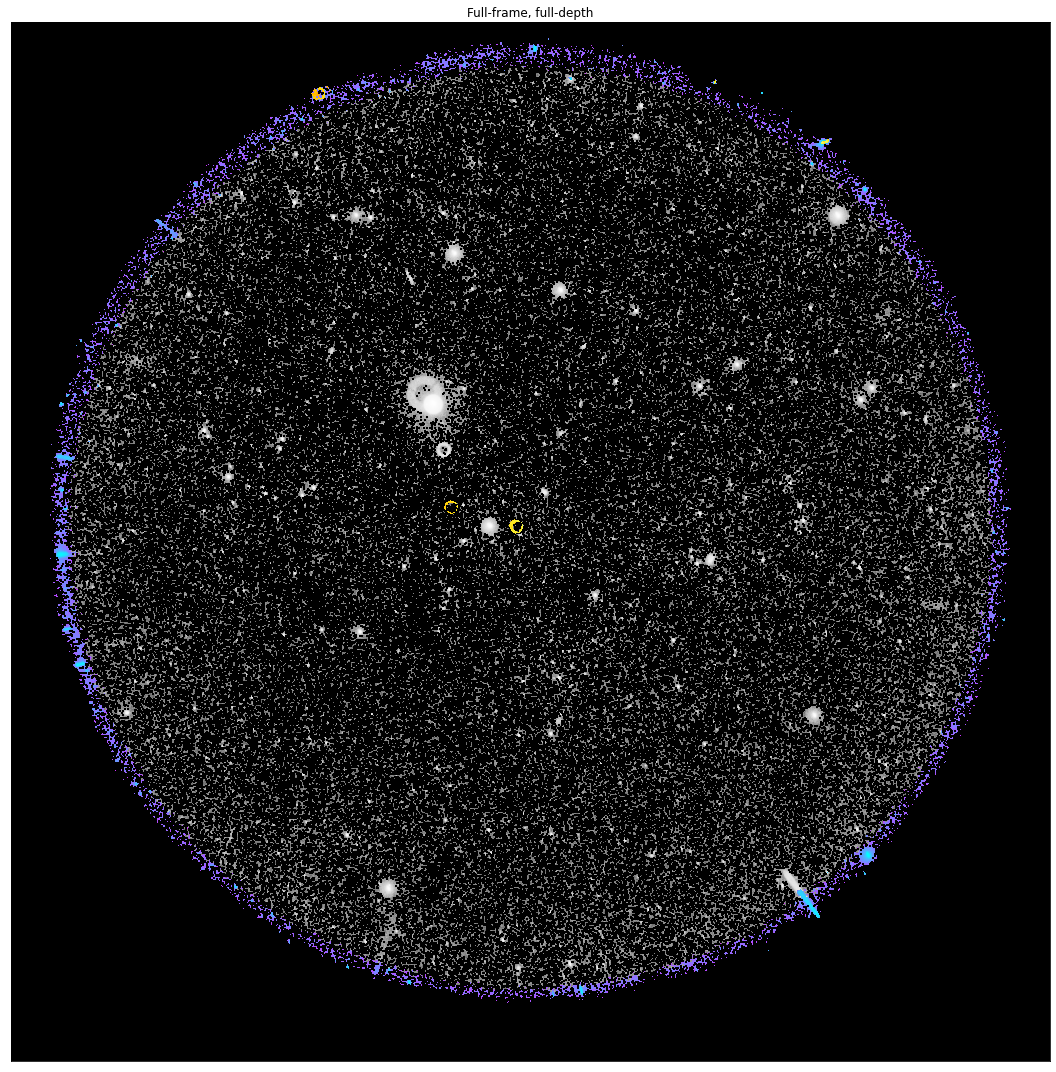

In [21]:
cntmap, flagmap, edgemap, wcs, trange, exptime = gfu.read_image(cntfilename)
plt.figure(figsize=(15, 15))
plt.title('Full-frame, full-depth')
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(1/np.sqrt(cntmap), cmap="Greys", origin="lower")
plt.imshow(1/np.sqrt(edgemap), origin="lower", cmap="cool") # "edge" events are blueish
plt.imshow(1/np.sqrt(flagmap), origin="lower", cmap="Wistia") # "hotspot" events are yellowish
plt.xticks([])
plt.yticks([])
plt.tight_layout()

print(f'Time range: {trange}\n')
print(f'Exposure time: {exptime}\n')
print(f'{wcs}')

Opened ../data/e13656/e13656-nd-mov.fits.gz
	Parsed file header.

15 images frames.

Time ranges: [[816379178.995, 816379298.995], [816379298.995, 816379418.995], [816379418.995, 816379538.995], [816379538.995, 816379658.995], [816379658.995, 816379778.995], [816379778.995, 816379898.995], [816379898.995, 816380018.995], [816380018.995, 816380138.995], [816380138.995, 816380258.995], [816380258.995, 816380378.995], [816380378.995, 816380498.995], [816380498.995, 816380618.995], [816380618.995, 816380738.995], [816380738.995, 816380858.995], [816380858.995, 816380978.995]]

Exposure times: [99.89534387874362, 108.2948546857536, 108.5475370233458, 100.9936855071996, 108.6073180701725, 108.9587637063089, 109.0084534329608, 109.0391590492263, 109.0225789172311, 108.9881125104146, 108.8282169828098, 104.2939701664094, 108.4074025359119, 108.2169646598949, 28.59566196115353]

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 24.707145171748  -17.96955374296633  
CR

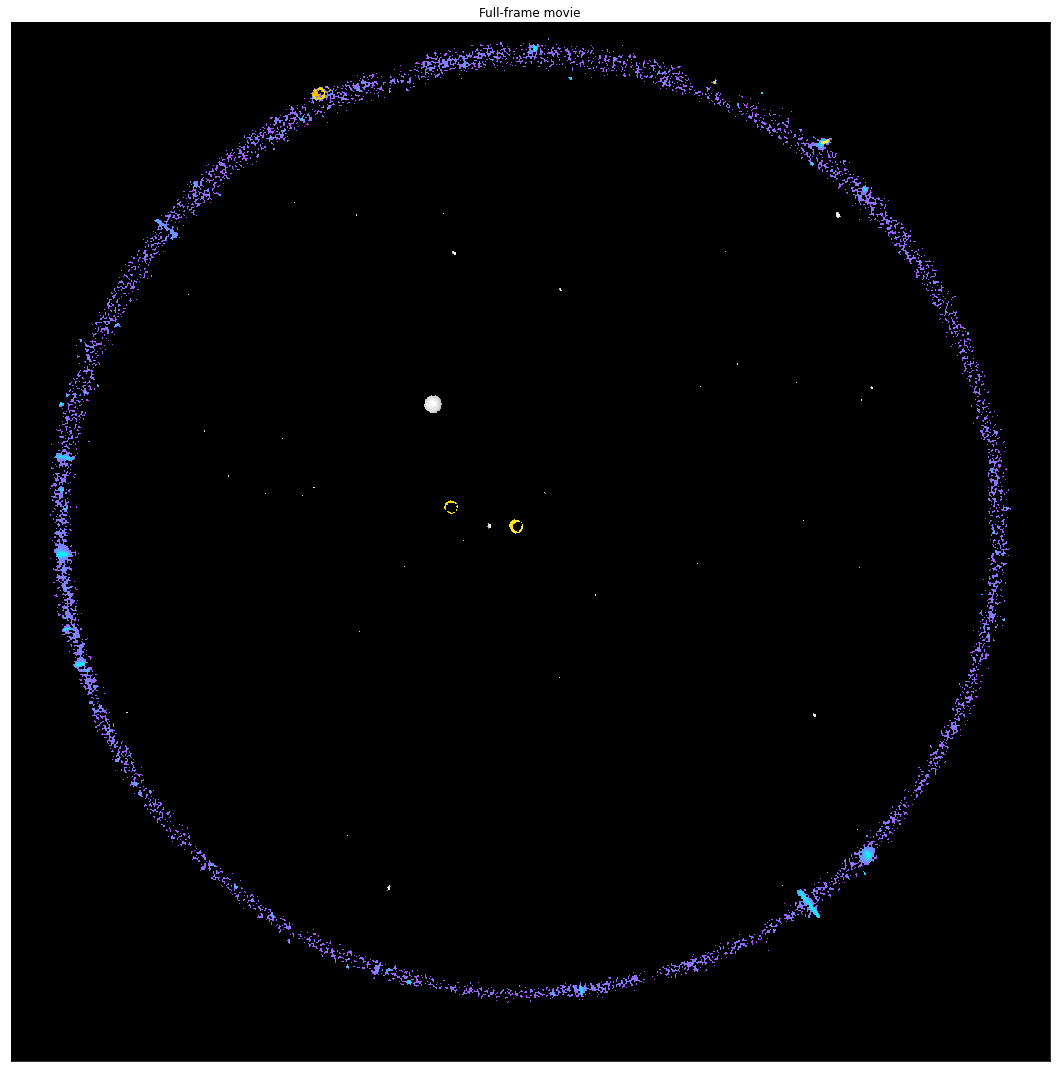

In [25]:
# This generates an animated movie of the scene and can take a few minutes...
# But it's worth it. The end result is really neat.
movmap, _, _, wcs, tranges, exptimes = gfu.read_image(movfilename)
    
print(f'\n{len(movmap)} images frames.\n')
print(f'Time ranges: {tranges}\n')
print(f'Exposure times: {exptimes}\n')
print(f'{wcs}')

# Create an animated image
fig = plt.figure(figsize=(15,15))
plt.title('Full-frame movie')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

ims = []
for i,frame in enumerate(movmap[:-1]): # eliminate the last frame, which always has lower exposure
    ims.append([
        plt.imshow(np.zeros(np.shape(frame)),cmap="Greys_r", animated=True),
        plt.imshow(1/np.sqrt(frame/exptimes[i]), cmap="Greys", origin="lower", animated=True),
        plt.imshow(1/np.sqrt(edgemap), origin="lower", cmap="cool", animated=True),
        plt.imshow(1/np.sqrt(flagmap), origin="lower", cmap="Wistia", animated=True),
    ])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat=True)

HTML(ani.to_html5_video())
#HTML(ani.to_jshtml()) # for an interactive animation

#NOTE: I don't know why this is displaying a duplicate image under the movie or how to make it stop doing that.

#### Generate an image stamp of the target source

([], [])

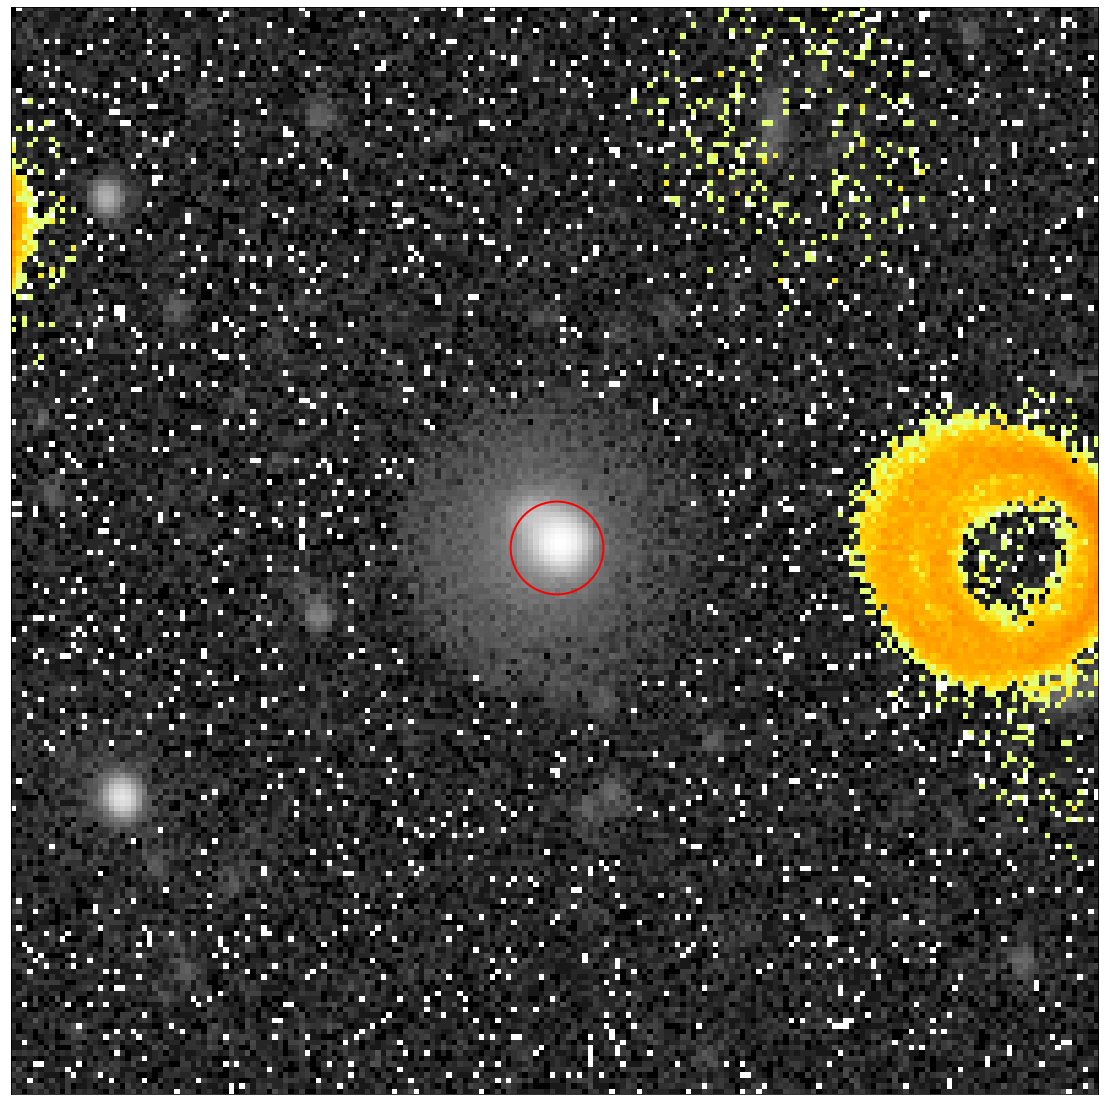

In [28]:
sz = 100 # half height / width of stamp in pixels
x,y = (1475, 1647) # pixel (xcenter, ycenter) copied from previous notebook
plt.figure(figsize=(20, 20))
plt.imshow(np.log10(cntmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Greys_r')
plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool')
plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia')
# Now overplot the aperture
photutils.CircularAperture([sz,sz], r=8.533333333333326).plot(color='red', lw=2, alpha=1)
plt.xticks([])
plt.yticks([])

#### And generate an movie stamp. Why not? It's the future.

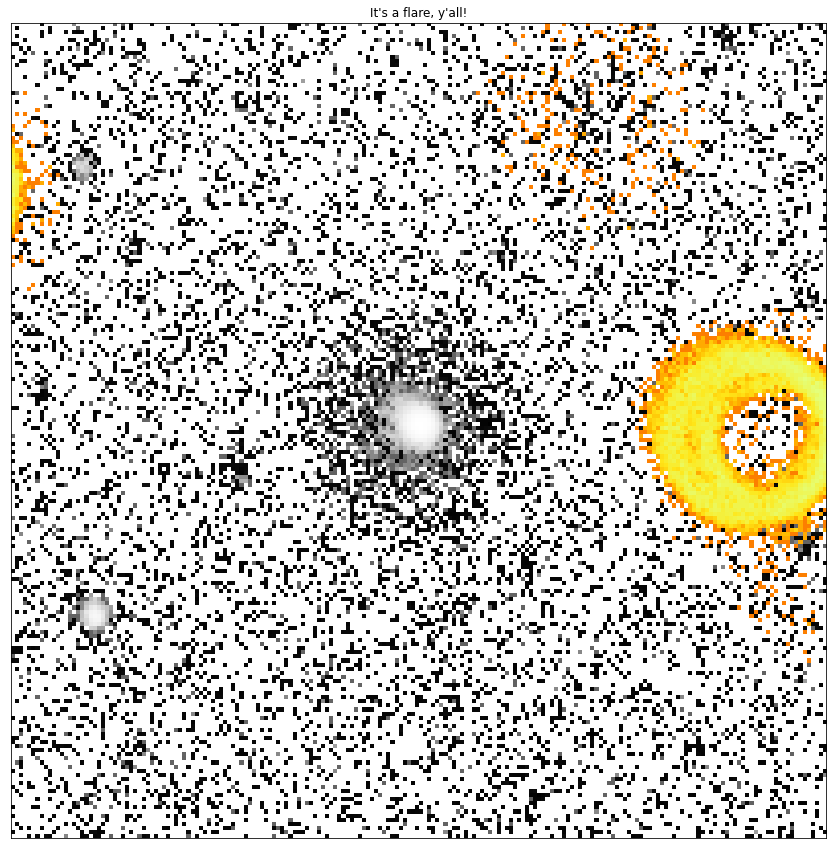

In [30]:
fig = plt.figure(figsize=(15,15))
plt.title("It's a flare, y'all!")
plt.xticks([])
plt.yticks([])

sz = 100 # half height / width of stamp in pixels
x,y = (1475, 1647) # pixel (xcenter, ycenter) copied from previous notebook

ims = []
for i,frame in enumerate(movmap[:-1]):
    ims.append([
        plt.imshow(1/np.sqrt(frame[y - sz : y + sz, x - sz : x + sz]/exptimes[i]),origin='lower',cmap='Greys', animated=True),
        plt.imshow(1/np.sqrt(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool', animated=True),
        plt.imshow(1/np.sqrt(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia', animated=True),
        #photutils.CircularAperture([sz,sz], r=8.533333333333326).plot(color='red', lw=2, alpha=1),
    ])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat=True)

HTML(ani.to_html5_video())
#HTML(ani.to_jshtml())

#NOTE: I don't know why this is displaying an image under the movie or how to make it stop.